In [1]:
!git clone -q https://github.com/DataHow/analytics-course-scripts.git

In [2]:
#@title Import libraries
import importlib
import ipywidgets as widgets
from ipywidgets import interact,interactive,fixed
from google.colab import output
output.enable_custom_widget_manager()

import numpy as np
import pandas as pd
import os
import importlib
import scipy.integrate
import scipy.stats
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.templates.default = "plotly_white"

# Script 0
# from pyDOE2 import fullfact, ff2n, ccdesign
# import definitive_screening_design as dsd

# Script 1
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.stats import chi2

process = importlib.import_module("analytics-course-scripts.interactions.modules.process_introduction")

In [3]:
#@title Functions for the script
FEED_START = (1, 4)
FEED_END = (8, 12)
FEED_RATE = (5, 20)
GLC_0 = (10, 80)
VCD_0 = (0.1, 1.0)
NUM_RUNS=40
DOE_DESIGN="Latin-Hypercube Sampling"


def run_pca_food():
  # Run PCA on data
  url="http://openmv.net/file/food-consumption.csv"
  food_cons_na=pd.read_csv(url,index_col=0)
  food_cons_na
  food_cons = food_cons_na.fillna(food_cons_na.mean())
  foodpca = PCA()
  foodpca.fit(food_cons)
  foodpca_x = list(range(1,foodpca.n_components_+1))
  food_components = foodpca.fit_transform(food_cons)
  return foodpca, food_cons

def plot_explained_variance_food():
  # Run PCA analysis
  foodpca, _ =run_pca_food()
  # Create explained variance plot
  foodpca_x = list(range(1,foodpca.n_components_+1))
  fig = px.line(x=foodpca_x, y=np.cumsum(foodpca.explained_variance_ratio_), color=px.Constant("Cumulative explained variance"), labels=dict(x="Principal component index", y="Explained Variance Ratio", color="Legend"))
  fig.add_bar(x=foodpca_x, y=foodpca.explained_variance_ratio_, name="Individual explained variance")
  fig.update_layout(width=1000)
  fig.show()

def plot_scores_loadings_food(pc_x_axis=1,pc_y_axis=2):
  # Run PCA analysis
  foodpca,food_cons =run_pca_food()
  food_components = foodpca.fit_transform(food_cons)
  food_loadings = foodpca.components_.T * np.sqrt(foodpca.explained_variance_)
  food_features = list(food_cons.columns)
  food_explained = foodpca.explained_variance_ratio_

  # Create scores and loadings plots
  fig = make_subplots(rows=2, cols=1, subplot_titles=["PCA scores plot", "PCA loadings plot"],vertical_spacing=0.08)
  fig.add_trace(go.Scatter(x=[0,0],y=[0,0],mode='markers', marker_color='black', name='origin'),row=1, col=1)
  fig.add_trace(go.Scatter(x=food_components[:,pc_x_axis-1],y=food_components[:,pc_y_axis-1], mode='markers+text', marker_size=10,text=food_cons.index.get_level_values(0),textposition="top center"), row=1,col=1)
  fig.add_trace(go.Scatter(x=[0,0],y=[0,0],mode='markers', marker_color='black', name='origin'),row=2, col=1)

  for i, feature in enumerate(food_features):
    fig.add_shape(type='line', x0=0, y0=0, x1=food_loadings[i, pc_x_axis-1], y1=food_loadings[i, pc_y_axis-1], row=2,col=1)
    fig.add_annotation(x=food_loadings[i, pc_x_axis-1], y=food_loadings[i, pc_y_axis-1], ax=0, ay=0, xanchor="center", yanchor="bottom", text=feature, row=2,col=1)
  fig.update_layout(width=1200, height=900, showlegend=False)
  fig.update_xaxes(title=f"{pc_x_axis}. Principal Component ({food_explained[pc_x_axis-1].round(2)}%)",row=2,col=1)
  fig.update_yaxes(title=f"{pc_y_axis}. Principal Component ({food_explained[pc_y_axis-1].round(2)}%)",row=1,col=1)
  fig.update_yaxes(title=f"{pc_y_axis}. Principal Component ({food_explained[pc_y_axis-1].round(2)}%)",row=2,col=1)

  fig.show()

def plot_owu_correlation(owu):
  owu = owu.drop(["timesteps"],axis=1)
  fig = px.imshow(owu.corr().round(3),text_auto = True)
  fig.update_layout(title='Correlation Matrix among X variables', width=1000)
  fig.show()

def plot_explained_variance_owu_raw(owu):
  owu = owu.drop(["timesteps"],axis=1)
  owupca = PCA()
  owupca.fit(owu)
  owupca_x = list(range(1,owupca.n_components_+1))

  fig = px.line(x=owupca_x, y=np.cumsum(owupca.explained_variance_ratio_), color=px.Constant("Cumulative explained variance"), labels=dict(x="Principal component index", y="Explained Variance Ratio", color="Legend"))
  fig.add_bar(x=owupca_x, y=owupca.explained_variance_ratio_, name="Individual explained variance")
  fig.update_layout(width=1000)
  fig.show()

def plot_explained_variance_owu(owu):
  owu = owu.drop(["timesteps"],axis=1)
  scaler = StandardScaler()
  owu_normalized = scaler.fit_transform(owu)
  # Run PCA on scaled data
  owupca = PCA()
  owupca.fit(owu_normalized)
  owupca_x = list(range(1,owupca.n_components_+1))

  fig = px.line(x=owupca_x, y=np.cumsum(owupca.explained_variance_ratio_), color=px.Constant("Cumulative explained variance"), labels=dict(x="Principal component index", y="Explained Variance Ratio", color="Legend"))
  fig.add_bar(x=owupca_x, y=owupca.explained_variance_ratio_, name="Individual explained variance")
  fig.update_layout(width=1000)
  fig.show()

def plot_scores_loadings_owu(owu,pc_x_axis=1,pc_y_axis=2,highlight_run=0):
  owu = owu.drop(["timesteps"],axis=1)
  scaler = StandardScaler()
  owu_normalized = scaler.fit_transform(owu)
  # Run PCA on scaled data
  owupca = PCA()
  owupca.fit(owu_normalized)
  owupca_x = list(range(1,owupca.n_components_+1))


  # Run PCA analysis
  owu_components = owupca.fit_transform(owu_normalized)
  owu_loadings = owupca.components_.T * np.sqrt(owupca.explained_variance_)
  owu_features = list(owu.columns)
  owu_explained = owupca.explained_variance_ratio_

  # Create scores and loadings plots
  fig = make_subplots(rows=2, cols=1, subplot_titles=["PCA scores plot", "PCA loadings plot"],vertical_spacing=0.08)
  fig.add_trace(go.Scatter(x=[0,0],y=[0,0],mode='markers', marker_color='black', name='origin'),row=1, col=1)
  text_data = [f"Run {owu.index.get_level_values(0)[i]}, Time {owu.index.get_level_values(1)[i]}" for i in range(len(owu))]
  fig.add_trace(go.Scatter(x=owu_components[:,pc_x_axis-1],y=owu_components[:,pc_y_axis-1], mode='markers', marker_size=10,text=text_data,textposition="top center"), row=1,col=1)
  highlight_run_ix = owu.index.get_level_values("run") == highlight_run
  fig.add_trace(go.Scatter(x=owu_components[highlight_run_ix,pc_x_axis-1],y=owu_components[highlight_run_ix,pc_y_axis-1], mode='lines+markers', marker_size=10, marker_color='black',line_color='black',text=text_data,textposition="top center"), row=1,col=1)


  fig.add_trace(go.Scatter(x=[0,0],y=[0,0],mode='markers', marker_color='black', name='origin'),row=2, col=1)
  for i, feature in enumerate(owu_features):
    fig.add_shape(type='line', x0=0, y0=0, x1=owu_loadings[i, pc_x_axis-1], y1=owu_loadings[i, pc_y_axis-1], row=2,col=1)
    fig.add_annotation(x=owu_loadings[i, pc_x_axis-1], y=owu_loadings[i, pc_y_axis-1], ax=0, ay=0, xanchor="center", yanchor="bottom", text=feature, row=2,col=1)
  fig.update_layout(width=1200, height=900, showlegend=False)
  fig.update_xaxes(title=f"{pc_x_axis}. Principal Component ({owu_explained[pc_x_axis-1].round(2)}%)",row=2,col=1)
  fig.update_yaxes(title=f"{pc_y_axis}. Principal Component ({owu_explained[pc_y_axis-1].round(2)}%)",row=1,col=1)
  fig.update_yaxes(title=f"{pc_y_axis}. Principal Component ({owu_explained[pc_y_axis-1].round(2)}%)",row=2,col=1)

  fig.show()


def plot_mahalanobis_distance_owu(owu,highlight_run=0):
  # owu = owu.drop(["timesteps"],axis=1)
  scaler = StandardScaler()
  owu_normalized = scaler.fit_transform(owu)
  # Run PCA on scaled data
  owupca = PCA()
  owupca.fit(owu_normalized)
  owupca_x = list(range(1,owupca.n_components_+1))
  # Run PCA analysis
  owu_components = owupca.fit_transform(owu_normalized)
  owu_loadings = owupca.components_.T * np.sqrt(owupca.explained_variance_)
  owu_features = list(owu.columns)
  owu_explained = owupca.explained_variance_ratio_
  # Calculate mahalanobis distance
  owu_mahalanobis = EmpiricalCovariance().fit(owu_components).mahalanobis(owu_components)
  T2threshold = chi2.ppf(0.95, owu_components.shape[1]-1)
  # Plot mahalanobis distance
  fig = px.bar(x=list(range(len(owu_mahalanobis))),y=owu_mahalanobis, labels=dict(x="OWU Observation Id.", y="Mahalanobis distance", color="Run_id"), title="Mahalanobis distance with 95% Confidence Interval", color=owu.index.get_level_values(0), color_continuous_scale=px.colors.cyclical.HSV)
  fig.add_hline(y=T2threshold)

  highlight_run_ix = owu.index.get_level_values("run") == highlight_run

  fig.add_trace(go.Bar(x=list(np.array(range(len(owu_mahalanobis)))[highlight_run_ix]), y=owu_mahalanobis[highlight_run_ix], marker_color='black'))
  fig.update_layout(width=1600, showlegend=False, coloraxis_showscale=False)
  fig.update_layout(barmode='overlay')
  fig.show()

# Principal Component Analysis

Find data underlying dimension that suffices to capture the information in the data, i.e., the latent variables.

We want to compress the information into a defined number of latent variables, such that `n_latent` $<$ `n_variables` .

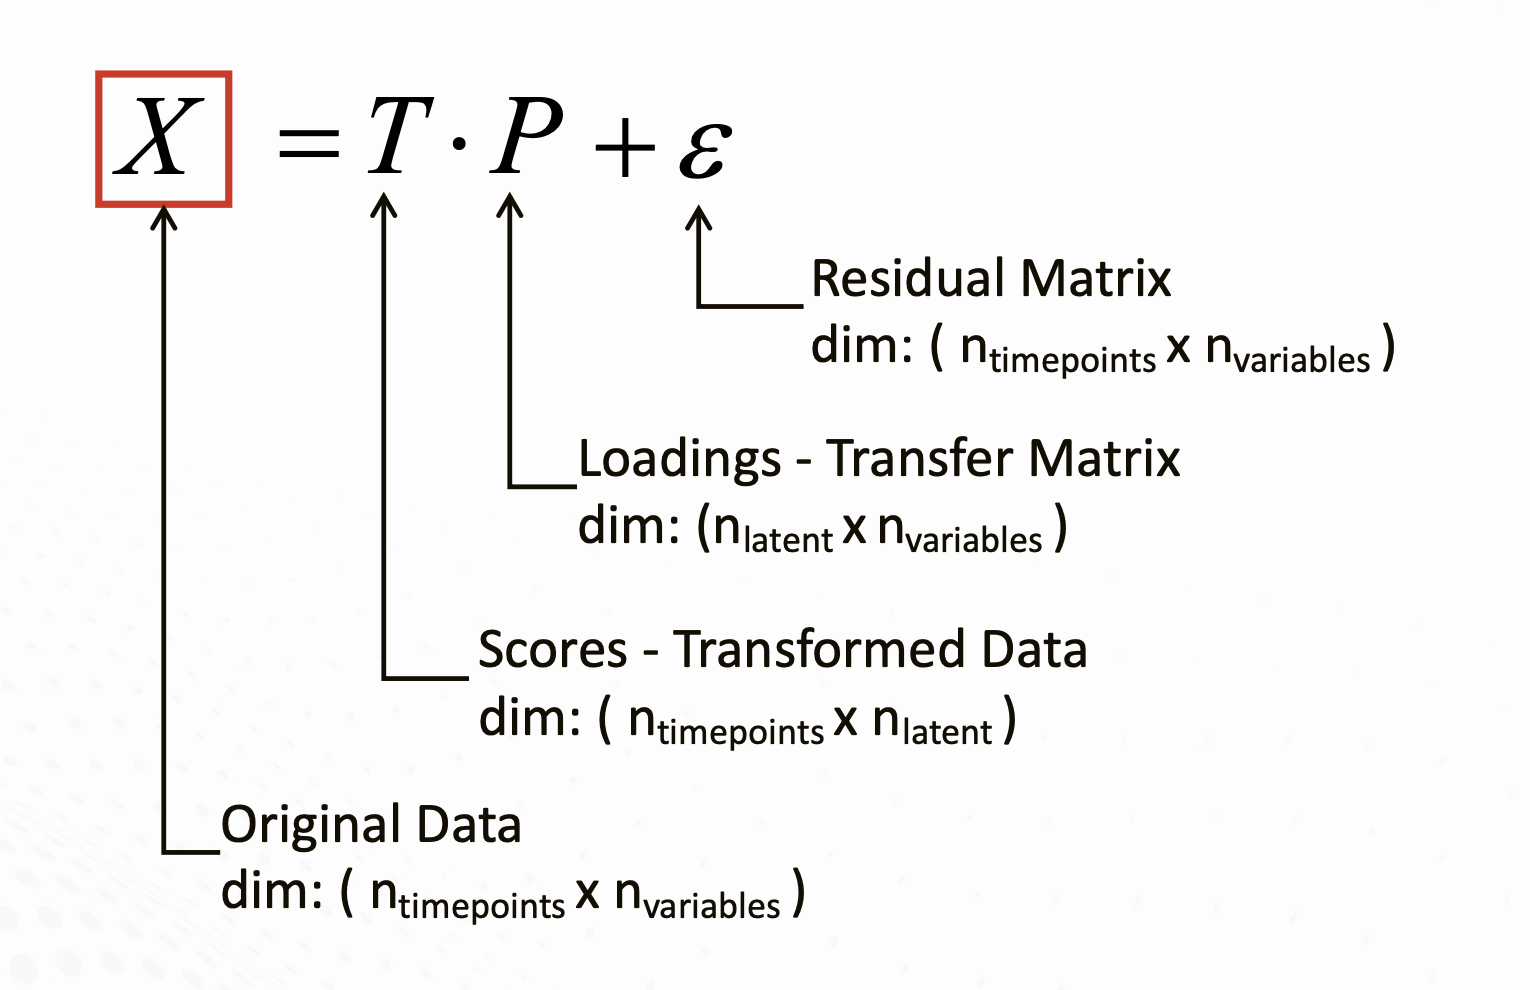

## Food Consumption Data

Use PCA to explore the differences between countries on their food consumption habits.

Source: Prosensus Course, Basel, 2014
Dataset available: http://openmv.net/info/food-consumption

### What are the options to deal with missing data?

In [4]:
pd.read_csv("http://openmv.net/file/food-consumption.csv",index_col=0)

,Real coffee,Instant coffee,Tea,Sweetener,Biscuits,Powder soup,Tin soup,Potatoes,Frozen fish,Frozen veggies,Apples,Oranges,Tinned fruit,Jam,Garlic,Butter,Margarine,Olive oil,Yoghurt,Crisp bread
Country,,,,,,,,,,,,,,,,,,,,
Germany,90,49,88,19.0,57.0,51,19,21,27,21,81,75,44,71,22,91,85,74,30.0,26
Italy,82,10,60,2.0,55.0,41,3,2,4,2,67,71,9,46,80,66,24,94,5.0,18
France,88,42,63,4.0,76.0,53,11,23,11,5,87,84,40,45,88,94,47,36,57.0,3
Holland,96,62,98,32.0,62.0,67,43,7,14,14,83,89,61,81,15,31,97,13,53.0,15
Belgium,94,38,48,11.0,74.0,37,23,9,13,12,76,76,42,57,29,84,80,83,20.0,5
Luxembourg,97,61,86,28.0,79.0,73,12,7,26,23,85,94,83,20,91,94,94,84,31.0,24
England,27,86,99,22.0,91.0,55,76,17,20,24,76,68,89,91,11,95,94,57,11.0,28
Portugal,72,26,77,2.0,22.0,34,1,5,20,3,22,51,8,16,89,65,78,92,6.0,9
Austria,55,31,61,15.0,29.0,33,1,5,15,11,49,42,14,41,51,51,72,28,13.0,11


In [12]:
px.imshow(pd.read_csv("http://openmv.net/file/food-consumption.csv",index_col=0))

## Questions:

### How can we analysie this data?

### What plots are usually used?


## Principal Component Analysis on Food Data

In [5]:
plot_explained_variance_food()

## Score and loading plot of PCA

1. Why do we see clusters of countries in the scoreplot?
2. How can we understand the differences between these clusters?

In [6]:
interactive(plot_scores_loadings_food, pc_x_axis=(1,6), pc_y_axis=(1,6))

interactive(children=(IntSlider(value=1, description='pc_x_axis', max=6, min=1), IntSlider(value=2, descriptio…

# Generate Dataset InSilico Dataset

We now use the same in-silico dataset that we have seen in precious use-case. We use the default design of experiment ranges and values from previous script and analysise these data using Principal Component Analysis

In [7]:
doe_array = process.generate_doe(FEED_START, FEED_END, FEED_RATE, GLC_0, VCD_0, NUM_RUNS)
owu, doe = process.generate_data(doe_array)
plot_owu_correlation(owu)

## Principal Component Analysis on In-silico data

In [8]:
plot_explained_variance_owu_raw(owu)



### Why are we able to explain 99% of variance with one principal component?

### What can we do to tackle this issue?

In [9]:
plot_explained_variance_owu(owu)

In [10]:
interactive(plot_scores_loadings_owu, owu=fixed(owu), pc_x_axis=(1,6), pc_y_axis=(1,6),highlight_run=(0,NUM_RUNS))

interactive(children=(IntSlider(value=1, description='pc_x_axis', max=6, min=1), IntSlider(value=2, descriptio…

In [11]:
interactive(plot_mahalanobis_distance_owu, owu=fixed(owu), highlight_run=(0,NUM_RUNS))

interactive(children=(IntSlider(value=0, description='highlight_run', max=40), Output()), _dom_classes=('widge…